In [1]:
# Transform csv to pkl file
import pandas as pd
import os

csv_train = pd.read_csv("../input/sdf-dsi-2022/train.csv")
csv_test = pd.read_csv("../input/sdf-dsi-2022/test.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
!pip install -q flaml 

In [3]:
!pip install -q dabl 
import dabl

## Load Dataset

In [4]:
import pandas as pd
import numpy as np
import pickle
import os

train = csv_train.drop(columns=[ 
                            "transaction_id",
                            "memo", 
                            "fee_account",  
                            "account",
                            "memo_type",
                            "prior_closed_at",
                            "time_bounds",
                            "current_ledger_sequence",
                            "prior_ledger_sequence",
                            "operation_types",
                            "surge_price_ind"])

train = train.fillna(0)

train_label = train.fee_charged
train_data = train.drop(columns="fee_charged")
attributes_train = train_data.columns

train.to_pickle("/".join((os.getcwd(), "train_processed.pkl")))

test = csv_test.drop(columns=[ 
                          "transaction_id",
                          "prior_ledger_sequence",
                          "prior_closed_at",
                          "time_bounds",
                          "fee_account",
                          "operation_types",
                          "memo",
                          "memo_type",
                          "account"])
test = test.fillna(0)

test.to_pickle("/".join((os.getcwd(), "test_processed.pkl")))

# Examine
attributes_test = test.columns

if not sorted(attributes_train) == sorted(attributes_test):
    print(sorted(attributes_train))
    print(sorted(attributes_test))
    assert Exception("attributes do not match!")

train_data.head()

,prior_successful_transaction_count,prior_failed_transaction_count,prior_operation_count,prior_successful_operation_count,prior_max_fee_charged,prior_min_fee_charged,prior_avg_fee_charged,transaction_operation_count,max_fee_bid,new_max_fee_bid
0,381,173,960,770,10000,100,173.285199,1,110,0.0
1,174,338,950,601,10000,100,185.546875,1,110,0.0
2,205,319,988,626,10000,100,188.549618,1,110,0.0
3,244,207,921,690,10000,100,204.212860,1,110,0.0
4,196,197,914,709,10000,100,232.569975,1,110,0.0


In [2]:
import pandas as pd
import numpy as np
import pickle
import os

with open("/".join((os.getcwd(), "train_processed.pkl")), 'rb') as f:
    train = pickle.load(f)
f.close()

train_label = train.fee_charged
train_data = train.drop(columns="fee_charged")


with open("/".join((os.getcwd(), "test_processed.pkl")), 'rb') as f:
    test = pickle.load(f)
f.close()

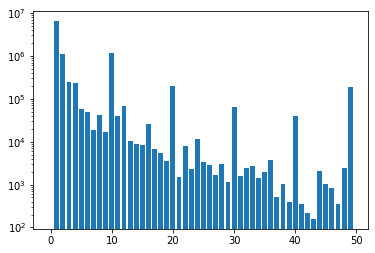

In [3]:
import matplotlib.pyplot as plt

# train_label_data = train_label.to_numpy()
# I am going to give 50 bins
bins = np.zeros((50, ))
for i, data in enumerate(train_label):
    index = int(min(49, data // 100))
    bins[index] += 1
plt.bar(range(len(bins)), bins)
plt.yscale("log")
plt.show()

In [4]:
downsample_limit = int(np.median(bins[1:-1]))
print(downsample_limit)

3677


In [5]:
weights = np.zeros((50, ))
for i, num in enumerate(bins):
    weights[i] = num / downsample_limit

weights = weights / weights.max()


In [6]:
import numpy as np
import numba as nb

@nb.jit
def distance(vecA, vecB):
    dist = (vecA - vecB) * (vecA - vecB).T
    return dist[0, 0]

@nb.jit(forceobj=True)
def nearest(point, cluster_centers):
    min_dist = float("inf")
    m = np.shape(cluster_centers)[0]
    for i in range(m):
        d = distance(point, cluster_centers[i, ])
        if min_dist > d:
            min_dist = d
    return min_dist


def get_centroids_idx(points, k):
    indices_ = list()
    m, n = np.shape(points)
    cluster_centers = np.mat(np.zeros((k , n)))
    index = np.random.randint(0, m)
    indices_.append(index)
    cluster_centers[0, ] = np.copy(points[index, ])
    d = [0.0 for _ in range(m)]

    for i in range(1, k):
        sum_all = 0
        for j in range(m):
            d[j] = nearest(points[j,:], cluster_centers[0:i,:])
            sum_all += d[j]
        sum_all *= random.random()
        for j, di in enumerate(d):
            sum_all -= di
            if sum_all > 0:
                continue
            cluster_centers[i] = np.copy(points[j, ])
            indices_.append(j)
            break
    return indices_
        

In [13]:
from sklearn.cluster import KMeans

def get_centroids_idx_kmeans(points, k):
    kmeans = KMeans(k, max_iter=1, n_init=1)
    kmeans.fit_transform(points)
    return kmeans.cluster_centers_.tolist()

In [20]:
import random

downsampled_train_data = []
weights_per_sampling = []
for i in range(50):
    thresh_low = i * 100
    thresh_high = (i+1) * 100
    if i < 49:
        mask = (train['fee_charged'] > thresh_low) & \
        (train['fee_charged'] < thresh_high)
    else:
        mask = (train['fee_charged'] > thresh_low)
    bined_data = train[mask]
    if len(bined_data.index) > downsample_limit:
        # Either randomly or strategically
        if np.random.random() > 0.5:
            indices = random.sample(range(len(bined_data.index)), downsample_limit-100)
            points = get_centroids_idx_kmeans(bined_data.values, 100)
            downsampled_bined_data = bined_data.iloc[indices, :].values.tolist()
            downsampled_bined_data.extend(points)
        else:
            indices = random.sample(range(len(bined_data.index)), downsample_limit)
            downsampled_bined_data = bined_data.iloc[indices, :].values.tolist()
        downsampled_train_data.extend(downsampled_bined_data)
        weights_per_sampling.extend([weights[i] for _ in range(downsample_limit)])
    else:
        downsampled_train_data.extend(bined_data.values.tolist())
        weights_per_sampling.extend([weights[i] for _ in range(len(bined_data.index))])
attributes_train_full = list(train.columns)
downsampled_train_data = pd.DataFrame(downsampled_train_data, columns=attributes_train_full)
downsampled_train_data.head()

,prior_successful_transaction_count,prior_failed_transaction_count,prior_operation_count,prior_successful_operation_count,prior_max_fee_charged,prior_min_fee_charged,prior_avg_fee_charged,transaction_operation_count,max_fee_bid,new_max_fee_bid,fee_charged
0,311.0,316.0,999.0,656.0,5500.0,110.0,175.438596,1.0,1000.0,0.0,110.0
1,244.0,435.0,1000.0,531.0,52920.0,2646.0,3896.907216,1.0,24042.0,0.0,121.0
2,167.0,306.0,942.0,620.0,10000.0,100.0,199.154334,1.0,150000.0,0.0,110.0
3,225.0,211.0,1000.0,752.0,20000.0,200.0,458.715596,1.0,20000.0,0.0,121.0
4,83.0,180.0,537.0,341.0,10000.0,100.0,204.182510,1.0,20001.0,0.0,110.0


In [21]:
downsampled_train_data_label = downsampled_train_data.fee_charged
downsampled_train_data_features = downsampled_train_data.drop(columns="fee_charged")

In [22]:
downsampled_train_data_features.head()

,prior_successful_transaction_count,prior_failed_transaction_count,prior_operation_count,prior_successful_operation_count,prior_max_fee_charged,prior_min_fee_charged,prior_avg_fee_charged,transaction_operation_count,max_fee_bid,new_max_fee_bid
0,311.0,316.0,999.0,656.0,5500.0,110.0,175.438596,1.0,1000.0,0.0
1,244.0,435.0,1000.0,531.0,52920.0,2646.0,3896.907216,1.0,24042.0,0.0
2,167.0,306.0,942.0,620.0,10000.0,100.0,199.154334,1.0,150000.0,0.0
3,225.0,211.0,1000.0,752.0,20000.0,200.0,458.715596,1.0,20000.0,0.0
4,83.0,180.0,537.0,341.0,10000.0,100.0,204.182510,1.0,20001.0,0.0


In [24]:
import dabl

preprocessor = dabl.EasyPreprocessor()
downsampled_train_data_features = dabl.clean(downsampled_train_data_features)
preprocessor.fit(downsampled_train_data_features)
downsampled_train_data_features = preprocessor.transform(downsampled_train_data_features)

In [25]:
test = dabl.clean(test)
test = preprocessor.transform(test)

In [26]:
len(downsampled_train_data_label) == len(weights_per_sampling)

True

In [28]:
from flaml import AutoML
from sklearn.ensemble import GradientBoostingRegressor

automl = AutoML()
settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": ['lgbm', 'xgboost', 'catboost'],  # list of ML learners
    "task": 'regression',  # task type    
    "log_file_name": 'stellar_blockchain.log',  # flaml log file
    "seed": 7654321,    # random seed
    "ensemble": {
        "final_estimator": GradientBoostingRegressor(
                           n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1,
                           random_state=42),
        "passthrough": False,
    },
    # "starting_points": "data", # very time-consuming
    # "fit_kwargs_by_estimator": {"lgbm": {"sample_weight": np.asarray(weights_per_sampling),}}
}
automl.fit(X_train=downsampled_train_data_features, y_train=downsampled_train_data_label, **settings)


[flaml.automl.automl: 03-20 18:05:18] {2726} INFO - task = regression
[flaml.automl.automl: 03-20 18:05:18] {2728} INFO - Data split method: uniform
[flaml.automl.automl: 03-20 18:05:18] {2731} INFO - Evaluation method: holdout
[flaml.automl.automl: 03-20 18:05:18] {2858} INFO - Minimizing error metric: 1-r2
[flaml.automl.automl: 03-20 18:05:18] {3004} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'catboost']
[flaml.automl.automl: 03-20 18:05:18] {3334} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-20 18:05:18] {3473} INFO - Estimated sufficient time budget=1984s. Estimated necessary time budget=3s.
[flaml.automl.automl: 03-20 18:05:18] {3525} INFO -  at 0.1s,	estimator lgbm's best error=0.8618,	best estimator lgbm's best error=0.8618
[flaml.automl.automl: 03-20 18:05:18] {3334} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-20 18:05:18] {3525} INFO -  at 0.1s,	estimator lgbm's best error=0.8618,	best estimator lgbm's best error=0.

In [29]:
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))

Best r2 on validation data: 0.2748


In [32]:
downsampled_train_data_features.shape

(105267, 9)

In [31]:
try:
    test.head()
except:
    print(test.shape)

(3500147, 9)


In [33]:
y_pred = automl.predict(test)

In [34]:
# quick correction
y_pred = np.where(y_pred < 100, 100, y_pred)

In [35]:
y_pred[:10]

array([2923.14331306, 1760.88940622, 1731.6581596 , 1992.7637538 ,
       1586.0421793 , 2261.36972614, 1466.51739695, 1562.31840987,
       1512.06850368, 3056.81034666])

## Feature Engineering

In [17]:
from itertools import combinations
from xgboost import XGBRegressor

columns_list = downsampled_train_data_features.columns
interactions = list(combinations(columns_list, 2))

interaction_dict = {}
for interaction in interactions:
    X_train_int = downsampled_train_data_features
    X_train_int['int'] = X_train_int[interaction[0]] * X_train_int[interaction[1]]
    lr3 = XGBRegressor(n_estimators=25, tree_method="gpu_hist")
    lr3.fit(X_train_int, downsampled_train_data_label)
    interaction_dict[lr3.score(X_train_int, downsampled_train_data_label)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction_dict[interaction])

('prior_failed_transaction_count', 'max_fee_bid')
('prior_failed_transaction_count', 'prior_max_fee_charged')
('prior_successful_transaction_count', 'max_fee_bid')
('prior_failed_transaction_count', 'transaction_operation_count')
('prior_max_fee_charged', 'prior_avg_fee_charged')


In [18]:
downsampled_train_data_features["new_feature"] = downsampled_train_data_features[interaction_dict[top_5[0]][0]] * downsampled_train_data_features[interaction_dict[top_5[0]][1]]


In [19]:
downsampled_train_data_features = downsampled_train_data_features.reindex(columns = list(attributes_train) + ["new_feature"])
downsampled_train_data_features["new_feature"] = downsampled_train_data_features["new_feature"].astype(float)

In [20]:
from flaml import AutoML
from sklearn.ensemble import GradientBoostingRegressor

automl = AutoML()
settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": ['lgbm', 'xgboost', 'catboost'],  # list of ML learners
    "task": 'regression',  # task type    
    "log_file_name": 'stellar_blockchain.log',  # flaml log file
    "seed": 7654321,    # random seed
    "ensemble": {
        "final_estimator": GradientBoostingRegressor(
                           n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1,
                           random_state=42),
        "passthrough": False,
    },
    # "fit_kwargs_by_estimator": {"lgbm": {"sample_weight": np.asarray(weights_per_sampling),}}
}
automl.fit(X_train=downsampled_train_data_features, y_train=downsampled_train_data_label, **settings)


[flaml.automl.automl: 03-20 03:53:58] {2726} INFO - task = regression
[flaml.automl.automl: 03-20 03:53:58] {2728} INFO - Data split method: uniform
[flaml.automl.automl: 03-20 03:53:58] {2731} INFO - Evaluation method: holdout
[flaml.automl.automl: 03-20 03:53:58] {2858} INFO - Minimizing error metric: 1-r2
[flaml.automl.automl: 03-20 03:53:58] {3004} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'catboost']
[flaml.automl.automl: 03-20 03:53:58] {3334} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-20 03:53:59] {3473} INFO - Estimated sufficient time budget=20279s. Estimated necessary time budget=36s.
[flaml.automl.automl: 03-20 03:53:59] {3525} INFO -  at 0.4s,	estimator lgbm's best error=0.7299,	best estimator lgbm's best error=0.7299
[flaml.automl.automl: 03-20 03:53:59] {3334} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-20 03:53:59] {3525} INFO -  at 0.4s,	estimator lgbm's best error=0.7299,	best estimator lgbm's best error=

In [21]:
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))

Best r2 on validation data: 0.5313


In [22]:
test["new_feature"] = test[interaction_dict[top_5[0]][0]] * test[interaction_dict[top_5[0]][1]]
test = test.reindex(columns = list(attributes_train) + ["new_feature"])
test["new_feature"] = test["new_feature"].astype(float)

In [23]:
test.head()

,prior_successful_transaction_count,prior_failed_transaction_count,prior_operation_count,prior_successful_operation_count,prior_max_fee_charged,prior_min_fee_charged,prior_avg_fee_charged,transaction_operation_count,max_fee_bid,new_max_fee_bid,new_feature
0,245,284,972,670,10000,100,183.742911,1,821.0,NaN,2.331640e+05
1,233,211,968,745,10000,100,218.018018,1,65272999.0,NaN,1.377260e+10
2,286,185,953,743,10000,100,202.335456,1,10000000.0,NaN,1.850000e+09
3,243,130,955,773,9000,100,256.032172,1,500.0,NaN,6.500000e+04
4,140,652,1000,335,860000,20000,25252.525253,1,9000000.0,NaN,5.868000e+09


In [24]:
y_pred = automl.predict(test)

In [25]:
# quick correction
y_pred = np.where(y_pred < 100, 100, y_pred)

## Polynomial Feature Transform

In [30]:
from sklearn.preprocessing import PolynomialFeatures
trans = PolynomialFeatures(degree=3)

poly_data = trans.fit_transform(downsampled_train_data_features)

In [33]:
poly_data.shape

(105267, 220)

In [34]:
from flaml import AutoML
from sklearn.ensemble import GradientBoostingRegressor

automl = AutoML()
settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": ['lgbm', 'xgboost', 'catboost'],  # list of ML learners
    "task": 'regression',  # task type    
    "log_file_name": 'stellar_blockchain.log',  # flaml log file
    "seed": 7654321,    # random seed
    "ensemble": {
        "final_estimator": GradientBoostingRegressor(
                           n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1,
                           random_state=42),
        "passthrough": False,
    },
    # "fit_kwargs_by_estimator": {"lgbm": {"sample_weight": np.asarray(weights_per_sampling),}}
}
automl.fit(X_train=poly_data, y_train=downsampled_train_data_label, **settings)


[flaml.automl.automl: 03-20 04:20:03] {2726} INFO - task = regression
[flaml.automl.automl: 03-20 04:20:03] {2728} INFO - Data split method: uniform
[flaml.automl.automl: 03-20 04:20:03] {2731} INFO - Evaluation method: holdout
[flaml.automl.automl: 03-20 04:20:03] {2858} INFO - Minimizing error metric: 1-r2
[flaml.automl.automl: 03-20 04:20:03] {3004} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'catboost']
[flaml.automl.automl: 03-20 04:20:03] {3334} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-20 04:20:04] {3473} INFO - Estimated sufficient time budget=55456s. Estimated necessary time budget=98s.
[flaml.automl.automl: 03-20 04:20:04] {3525} INFO -  at 0.8s,	estimator lgbm's best error=0.8804,	best estimator lgbm's best error=0.8804
[flaml.automl.automl: 03-20 04:20:04] {3334} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-20 04:20:04] {3525} INFO -  at 1.1s,	estimator lgbm's best error=0.8804,	best estimator lgbm's best error=

In [ ]:
poly_test = trans.transform(test)
y_pred = automl.predict(poly_test)
y_pred = np.where(y_pred < 100, 100, y_pred)

## Submit final prediction

In [36]:
sample_submit = pd.read_csv("/".join(("../input/sdf-dsi-2022", "sample_submission.csv")))
sample_submit.predicted_fee = y_pred
sample_submit.to_csv("./submission.csv", index=None)